In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os
import shutil

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud import ml
from tqdm import tqdm

from dataclasses import dataclass
from collections import defaultdict

from numba import njit

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent.parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12, 0.04, 0.06, 0.07], '_status': {}}

In [4]:
"634e14bc75836df75158fb15f379d8bb"

'634e14bc75836df75158fb15f379d8bb'

In [12]:

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "ESL":
        continue
    
    experiments = sorted(glob.glob(job.fn("longer_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", "_")
        temp = utils.extract_between(exper, "temp-", "/")
        iter = utils.extract_between(exper, "iter-", ".gsd")

        traj = gsd.hoomd.open(exper)
        print(exper)
        break
    break

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
/media/ian/Data2/monk/2d-osc-shear/workspace/7ec2f6aca035e69077eab24383a21cb6/longer_experiments/max-shear-0.01/temp-1.4877e-01/traj-fire_period-1000.0.gsd


In [13]:
# fire minimize further

sim = hoomd.Simulation(device=hoomd.device.GPU())

sim.create_state_from_gsd(filename=exper)

integrator = hoomd.md.minimize.FIRE(0.00025, 1e-3, 1, 1e-5)
nve = hoomd.md.methods.NVE(hoomd.filter.All())

nlist = hoomd.md.nlist.Tree(0.3)
kalj = pair.KA_LJ(nlist)
integrator.forces.append(kalj)
integrator.methods.append(nve)

sim.operations.integrator = integrator


In [14]:
i = 0
energies = []
while not integrator.converged:
    sim.run(10_000)
    print(i)
    
    energies.append(kalj.energy)
    
    if i > 100:
        break
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


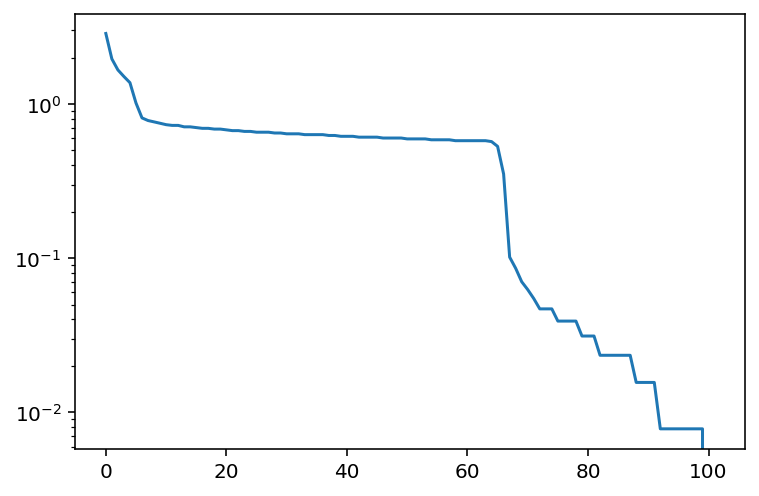

In [15]:
plt.plot(energies - np.min(energies))
plt.yscale('log')

In [16]:
hoomd.write.GSD.write(state=sim.state, filename=f"test2.gsd")

In [17]:
traj = gsd.hoomd.open("test2.gsd")

In [18]:
import importlib
import matspy
import qlm
importlib.reload(qlm);

In [19]:
import scipy.sparse as ssp

In [20]:
lj = qlm.KobAndersenLJ()
computer = qlm.QLM(lj)

In [21]:
hess = computer.compute_hessian(traj[-1])

In [22]:
hess_dense = computer.compute_hessian(traj[-1], dense=True)

TypeError: not enough arguments: expected 6, got 5

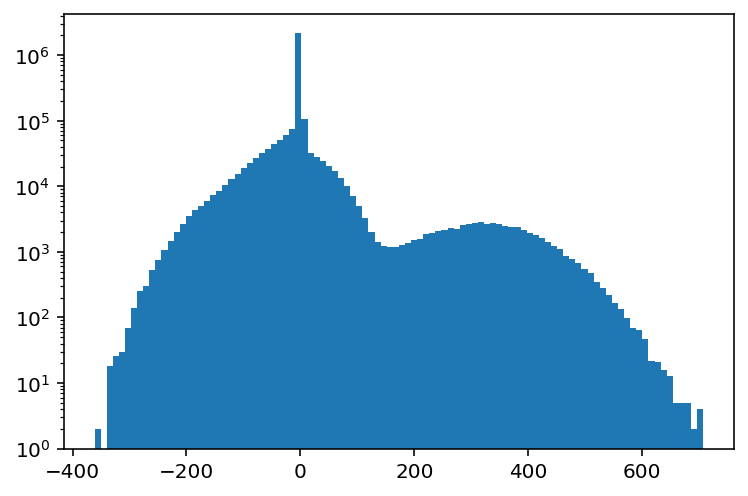

In [23]:
plt.hist(hess.data, bins=100)
plt.yscale("log");

In [24]:
hess[:5, :5].toarray().astype(np.float16)

array([[539.5  ,   6.645,   0.   ,   0.   ,   0.   ],
       [  6.645, 499.5  ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   , 475.5  , -50.72 ,   0.   ],
       [  0.   ,   0.   , -50.72 , 437.5  ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   , 378.5  ]], dtype=float16)

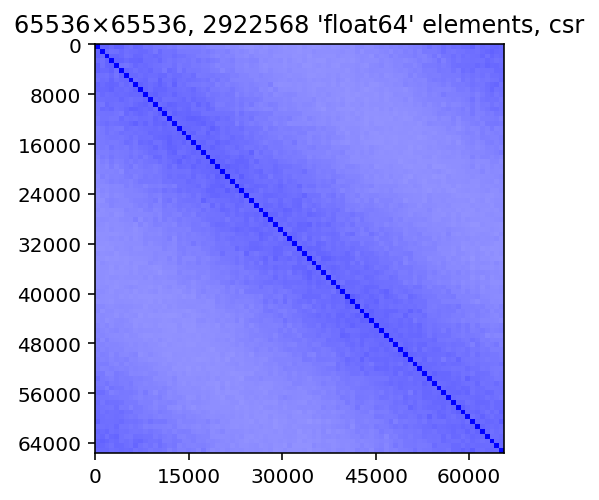

In [25]:
matspy.spy(hess)

In [26]:
importlib.reload(qlm);

In [27]:
lj = qlm.KobAndersenLJ()
computer = qlm.QLM(lj)

In [28]:
output = computer.compute(traj[-1], sigma=0.0, k=20, filter=False)

In [29]:
evals = output[0]

In [30]:
evals

array([-9.41484377e-09,  2.58968872e-15,  5.07249532e-15,  1.92581421e-02,
        1.98227884e-02,  2.02247736e-02,  2.10470523e-02,  3.95793943e-02,
        4.01347988e-02,  4.15515383e-02,  4.18145628e-02,  7.67367384e-02,
        7.75421294e-02,  7.83577487e-02,  8.22952914e-02,  9.25248828e-02,
        9.47457320e-02,  9.75116816e-02,  9.85350901e-02,  1.00145230e-01])

(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 2., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 2.]),
 array([-9.41484377e-09,  2.00289538e-03,  4.00580018e-03,  6.00870498e-03,
         8.01160978e-03,  1.00145146e-02,  1.20174194e-02,  1.40203242e-02,
         1.60232290e-02,  1.80261338e-02,  2.00290386e-02,  2.20319434e-02,
         2.40348482e-02,  2.60377530e-02,  2.80406578e-02,  3.00435626e-02,
         3.20464673e-02,  3.40493721e-02,  3.60522769e-02,  3.80551817e-02,
         4.00580865e-02,  4.20609913e-02,  4.40638961e-02,  4.60668009e-02,
         4.80697057e-02,  5.00726105e-02,  5.20755153e-02,  5.40784201e-02,
         5.60813249e-02,  5.80842297e-02,  6.00871345e-02,  6.20900393e-02,
         6.40929441e-02,  6.60958489e-02,  6.80987537e-02,  7.01016585e-02,
         7.21045633e-02,  7.41074681e-02,  7.61103729e-02,  7.81132777e-02,
         8.011

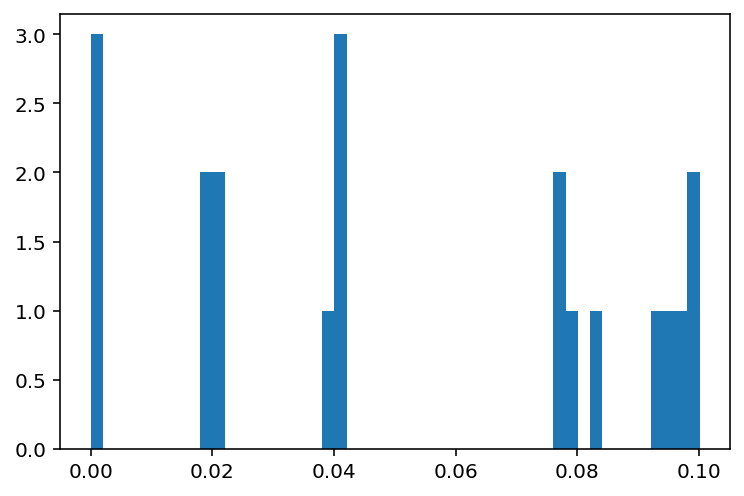

In [31]:
plt.hist(evals, bins=50)

(array([3., 0., 0., 2., 2., 0., 0., 1., 3., 0., 0., 0., 0., 0., 0., 3., 1.,
        0., 2., 3.]),
 array([-9.41484377e-09,  5.00725258e-03,  1.00145146e-02,  1.50217766e-02,
         2.00290386e-02,  2.50363006e-02,  3.00435626e-02,  3.50508245e-02,
         4.00580865e-02,  4.50653485e-02,  5.00726105e-02,  5.50798725e-02,
         6.00871345e-02,  6.50943965e-02,  7.01016585e-02,  7.51089205e-02,
         8.01161825e-02,  8.51234445e-02,  9.01307065e-02,  9.51379685e-02,
         1.00145230e-01]),
 <BarContainer object of 20 artists>)

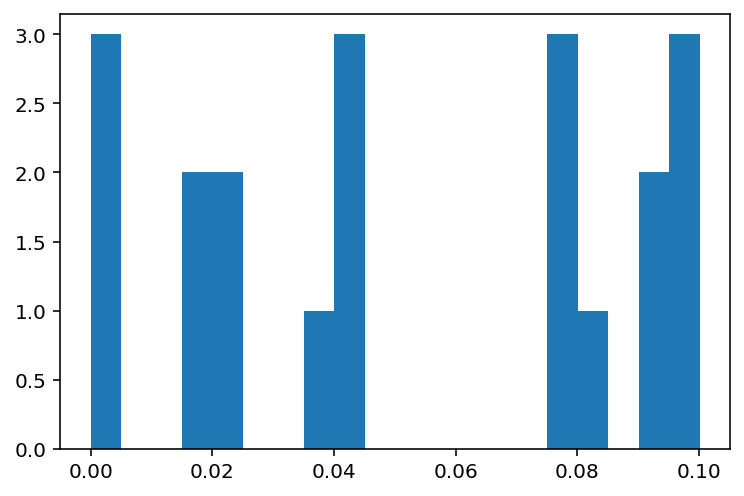

In [32]:
plt.hist(evals, bins=20)

In [33]:
N = traj[-1].particles.N

In [34]:
evals

array([-9.41484377e-09,  2.58968872e-15,  5.07249532e-15,  1.92581421e-02,
        1.98227884e-02,  2.02247736e-02,  2.10470523e-02,  3.95793943e-02,
        4.01347988e-02,  4.15515383e-02,  4.18145628e-02,  7.67367384e-02,
        7.75421294e-02,  7.83577487e-02,  8.22952914e-02,  9.25248828e-02,
        9.47457320e-02,  9.75116816e-02,  9.85350901e-02,  1.00145230e-01])

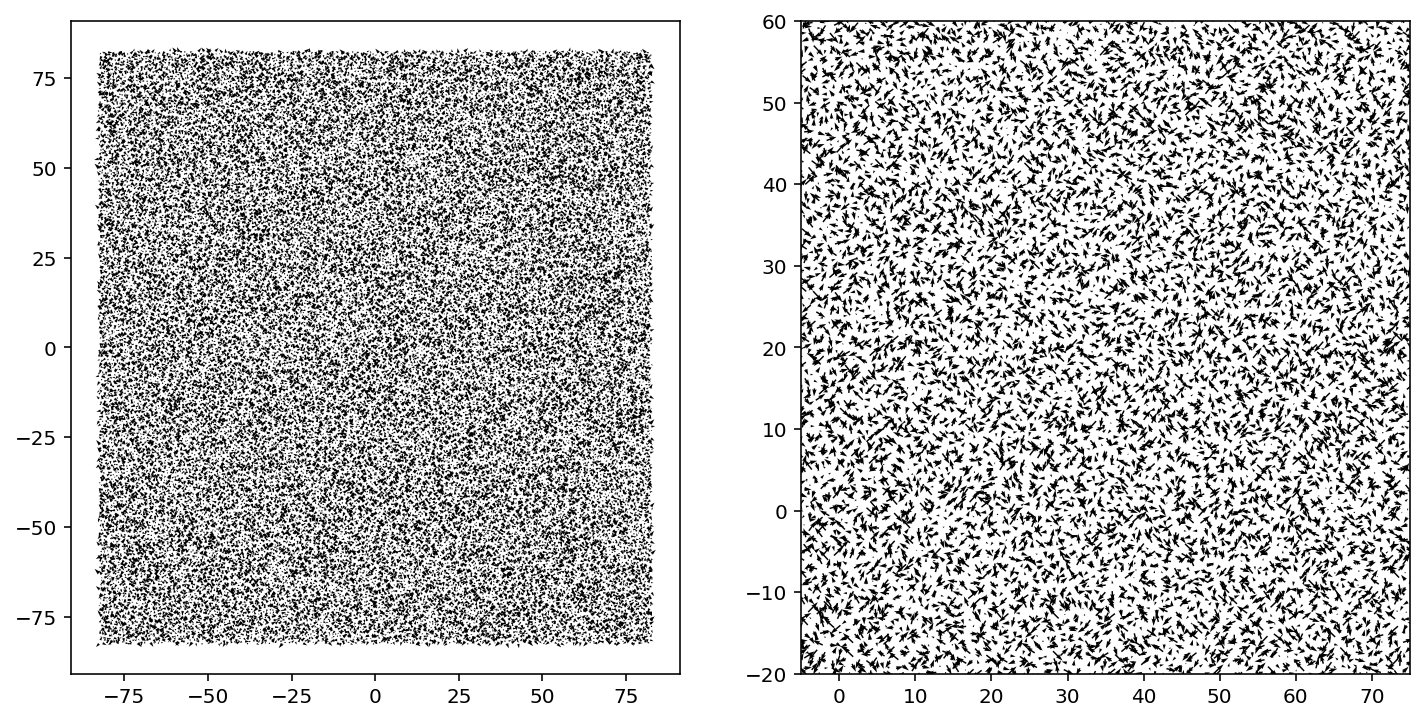

In [59]:
evec = output[1][0].reshape(N, 2) # len N*dim
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

s = 0.005

pos = traj[-1].particles.position[:,:2]
plt.sca(axs[0])
plt.quiver(pos[:,0], pos[:,1], evec[:,0], evec[:,1], scale=s, scale_units='xy')
L = None
if L is not None:
    plt.xlim(-L/2, L/2)
    plt.ylim(-L/2, L/2)

# plt.figure()
plt.sca(axs[1])
plt.quiver(pos[:,0], pos[:,1], evec[:,0], evec[:,1], scale=s, scale_units='xy')
L = 80
lx = 35
ly = 20
if L is not None:
    plt.xlim(-L/2 + lx, L/2 + lx)
    plt.ylim(-L/2 + ly, L/2 + ly)

In [241]:
np.savez("eig", evecs=output[1], evals=evals)

In [242]:
importlib.reload(qlm);
lj = qlm.KobAndersenLJ()
computer = qlm.QLM(lj)

In [264]:
filtered_modes = computer.filter_modes(traj[-1], output[1][:100])

100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


In [256]:
np.savez("eig-filtered-small-neg", evecs=filtered_modes, evals=evals)

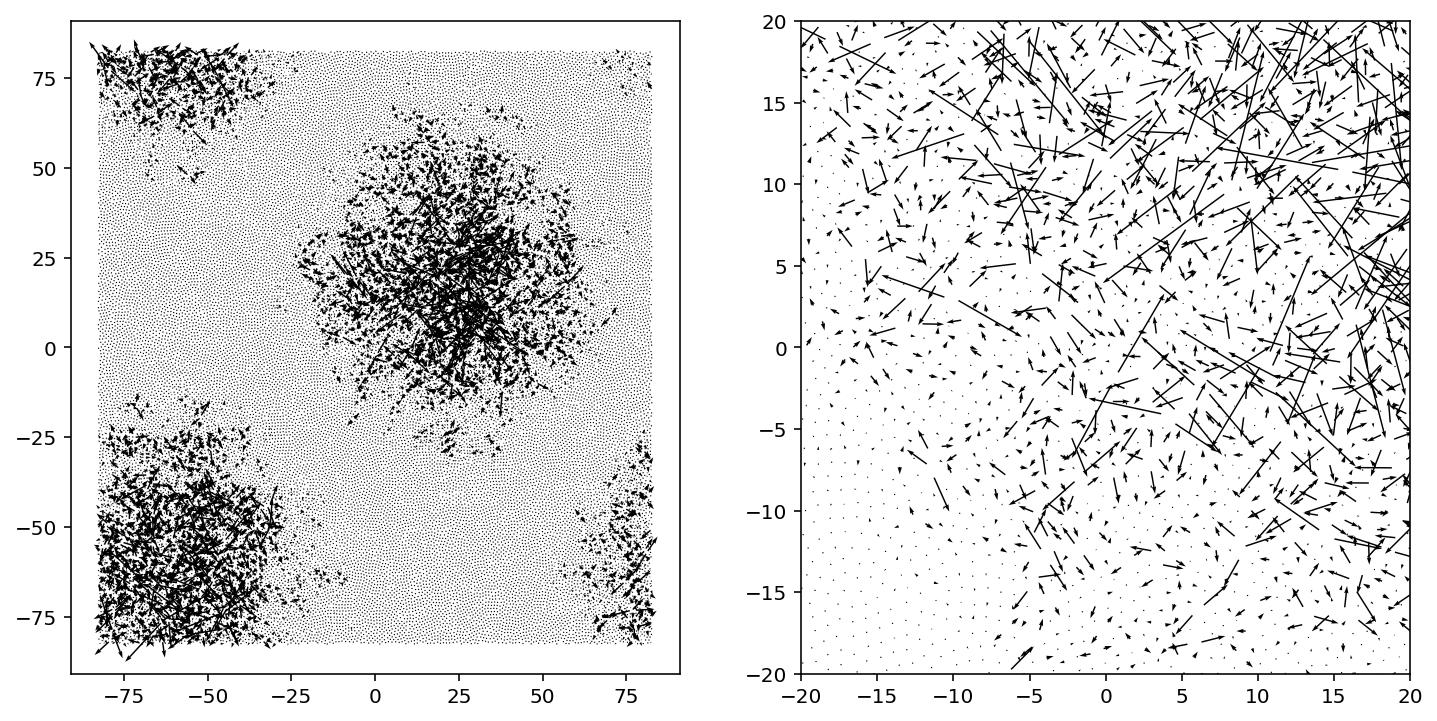

In [258]:
n = 2
evec = filtered_modes[n].reshape(N, 2).copy() # len N*dim
evec /= np.linalg.norm(evec)
# evec = np.log(np.abs(evec) + 1e-6) * np.sign(evec)
# plot eigenvectors
# plt.figure(figsize=(6, 6))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scale = 0.005

pos = traj[-1].particles.position[:,:2]
plt.sca(axs[0])
plt.quiver(pos[:,0], pos[:,1], evec[:,0], evec[:,1], scale=scale, scale_units='xy')
L = None
if L is not None:
    plt.xlim(-L/2, L/2)
    plt.ylim(-L/2, L/2)

# plt.figure()
plt.sca(axs[1])
plt.quiver(pos[:,0], pos[:,1], evec[:,0], evec[:,1], scale=scale, scale_units='xy')
L = 40
if L is not None:
    plt.xlim(-L/2, L/2)
    plt.ylim(-L/2, L/2)

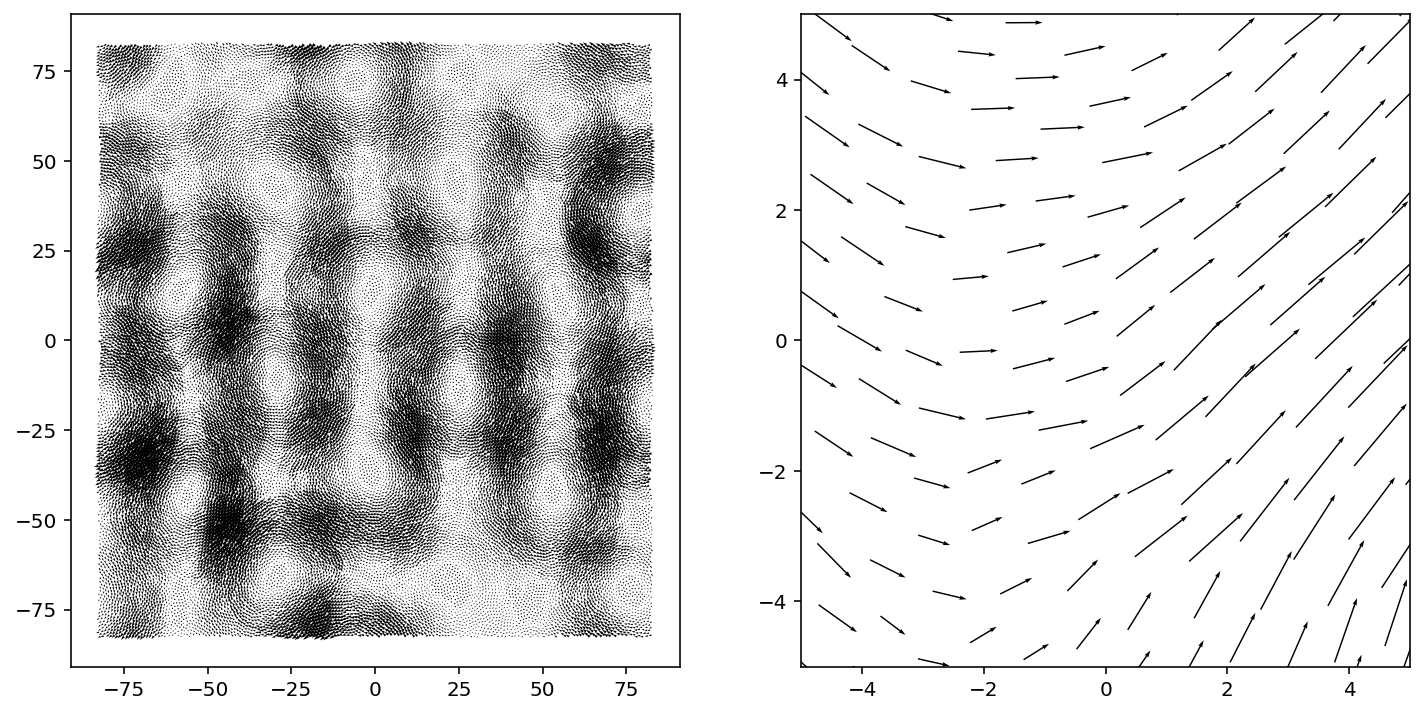

In [240]:
evec = output[1][n].reshape(N, 2).copy() # len N*dim

# plot eigenvectors
# plt.figure(figsize=(6, 6))
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scale = 0.005

pos = traj[-1].particles.position[:,:2]
plt.sca(axs[0])
plt.quiver(pos[:,0], pos[:,1], evec[:,0], evec[:,1], scale=scale, scale_units='xy')
L = None
if L is not None:
    plt.xlim(-L/2, L/2)
    plt.ylim(-L/2, L/2)

# plt.figure()
plt.sca(axs[1])
plt.quiver(pos[:,0], pos[:,1], evec[:,0], evec[:,1], scale=scale, scale_units='xy')
L = 10
if L is not None:
    plt.xlim(-L/2, L/2)
    plt.ylim(-L/2, L/2)

In [222]:
np.linalg.norm(output[1][1000])

1.0000000000000002

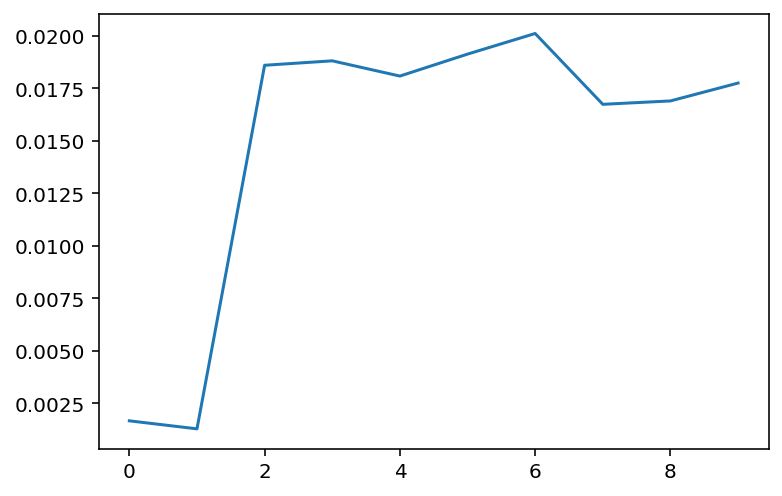

In [263]:
plt.plot(np.linalg.norm(filtered_modes, axis=1)/evals[:10])